In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters, measure
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#load image
img = Image.open("image1.tiff")
img = np.asarray(img)

In [3]:
#convert rgb to grayscale, usign weighted sum
if len(img.shape) == 3 and img.shape[2] == 3:
    img = np.dot(img[..., :3], [0.2989, 0.587, 0.114]) 

In [4]:
#smoothing + thresholding
smoothed_image = gaussian_filter(img, sigma=1)

from skimage.filters import threshold_otsu
threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

Otsu's Threshold: 187.95820176182838


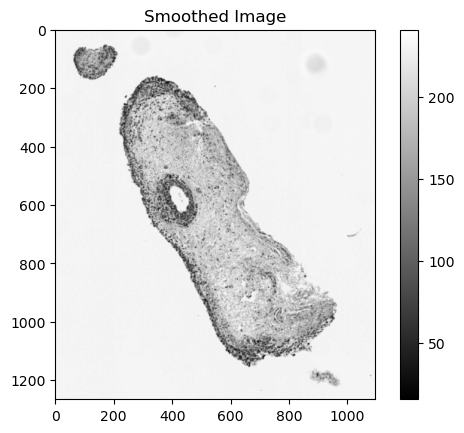

In [5]:
#segmenting
segmented_image = smoothed_image < threshold_value

plt.imshow(smoothed_image, cmap='gray')
plt.title("Smoothed Image")
plt.colorbar()
plt.show()

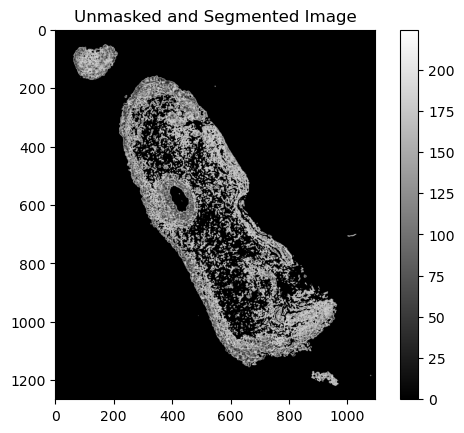

In [6]:
#unmasking
unmasked_image = np.zeros_like(img)
unmasked_image[segmented_image] = img[segmented_image]

plt.imshow(unmasked_image, cmap='gray')
plt.title("Unmasked and Segmented Image")
plt.colorbar()
plt.show()

In [7]:
#convert to 8-bit
binary_image = np.where(segmented_image, 255, 0).astype(np.uint8)


Number of contours found: 852


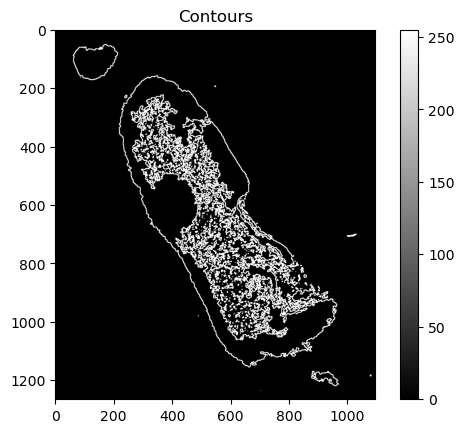

In [8]:
#identifying contours -- identifies the edges or boundaries of tissue layers
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours)}")

contour_image = np.zeros_like(binary_image)
cv2.drawContours(contour_image, contours, -1, 255, thickness=2)

plt.imshow(contour_image, cmap='gray')
plt.title("Contours")
plt.colorbar()
plt.show()

In [22]:
#filter contours by area
min_area = 1  #CALCULATE THRESHOLD??
max_area = 2000  #CALCULATE THRESHOLD?? -- need to figure out area

filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
print(f"Number of filtered contours (area-based): {len(filtered_contours)}")

Number of filtered contours (area-based): 620


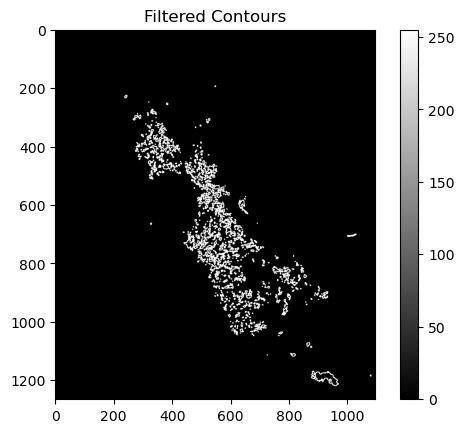

In [23]:
#draw contours on a blank canvas
filtered_contour_image = np.zeros_like(binary_image)
cv2.drawContours(filtered_contour_image, filtered_contours, -1, 255, thickness=2)

plt.imshow(filtered_contour_image, cmap='gray')
plt.title("Filtered Contours")
plt.colorbar()
plt.show()

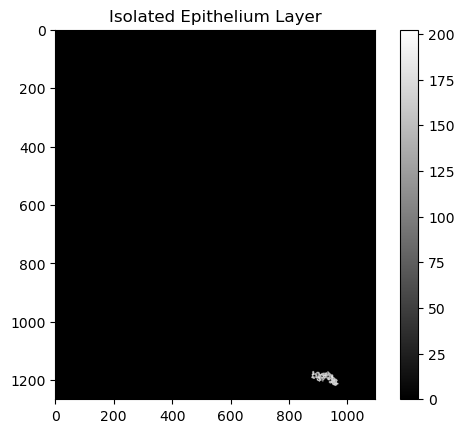

In [24]:
#isolate  epithelium region based on the best contour match
if filtered_contours:
    #asssuming the epithelium is the contour with the largest area
    best_contour = max(filtered_contours, key=cv2.contourArea)

    #create a mask to isolate the epithelium region
    epithelium_mask = np.zeros_like(binary_image)
    cv2.drawContours(epithelium_mask, [best_contour], -1, 255, thickness=cv2.FILLED)

    #apply the mask to isolate the epithelium from the original image
    isolated_epithelium = cv2.bitwise_and(unmasked_image, unmasked_image, mask=epithelium_mask)

    plt.imshow(isolated_epithelium, cmap='gray')
    plt.title("Isolated Epithelium Layer")
    plt.colorbar()
    plt.show()
else:
    print("No epithelium contour found")

